In [190]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


In [191]:
RISKY_ASSET = 'AAPL' #INPUT STOCK HERE
START_DATE = '2010-12-31'
END_DATE = '2014-12-31'

In [192]:


# momentum factor
df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', 
                        start=START_DATE)[0]
df_mom.index = df_mom.index.format()

# five factors
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                                'famafrench', 
                                start=START_DATE)[0]
df_five_factor.index = df_five_factor.index.format()
df_five_factor
asset_df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, 
                       #auto_adjust=True
                       progress=False)
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'return'


# join all datasets on the index
five_factor_data = df_five_factor.join(y)


# rename columns
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 
                            'rf', 'rtn']

# divide everything (except returns) by 100
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

# select period of interest
five_factor_data = five_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf

five_factor_data.head()



# Specify the path to the Excel file
excel_file_path = "CentralityData.xlsx"

# Load the Excel file into a DataFrame
df = pd.read_excel(excel_file_path)

df = df.rename(columns={df.columns[0]: 'Date'})

df.head()

df['Date'] = pd.to_datetime(df['Date'])

# Extract year and month from the 'Date' column and create a new column
df['YearMonth'] = df['Date'].dt.strftime('%Y-%m')
df.head()

# Set 'YearMonth' column as the index
df = df.set_index('YearMonth')
df=df.drop(columns='Date',axis=1)

new_columns = {col: f'Cent_{col}' for col in df.columns}
df = df.rename(columns=new_columns)
df = df / 100
df.head()

df = pd.merge(five_factor_data, df, left_index=True, right_index=True, how='inner')





six_factor_data=df


Stock_OLS = 'Cent_' + RISKY_ASSET


six_factor_data.head()



six_factor_model = smf.ols(
    formula='excess_rtn ~ mkt + smb + hml + rmw + cma +' +Stock_OLS,
    data=six_factor_data
).fit()

print(six_factor_model.summary())



C:\Users\clint\AppData\Local\Temp\ipykernel_10216\3112311507.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench',
C:\Users\clint\AppData\Local\Temp\ipykernel_10216\3112311507.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench',
C:\Users\clint\AppData\Local\Temp\ipykernel_10216\3112311507.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3',
C:\User

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     4.991
Date:                Sat, 20 May 2023   Prob (F-statistic):           0.000642
Time:                        20:28:16   Log-Likelihood:                 71.260
No. Observations:                  48   AIC:                            -128.5
Df Residuals:                      41   BIC:                            -115.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0278      0.021     -1.317      0.1

In [193]:
rf = six_factor_data['rf'].mean()
market_premium = six_factor_data['mkt'].mean()
smb_premium = six_factor_data['smb'].mean()
hml_premium = six_factor_data['hml'].mean()
rmw_premium=six_factor_data['rmw'].mean()
cma_premium=six_factor_data['cma'].mean()
Cent_premium=six_factor_data[Stock_OLS].mean()

intercept, b1, b2, b3,b4,b5,b6 = six_factor_model.params

expected_monthly_return = rf + b1 * market_premium + b2 * smb_premium + b3 * hml_premium +b4 * rmw_premium + b5 * cma_premium +b6*Cent_premium
expected_yearly_return = expected_monthly_return * 12
print("Expected yearly return:" + str(expected_yearly_return))


Expected yearly return:0.603318538838925


Number of rows: 48


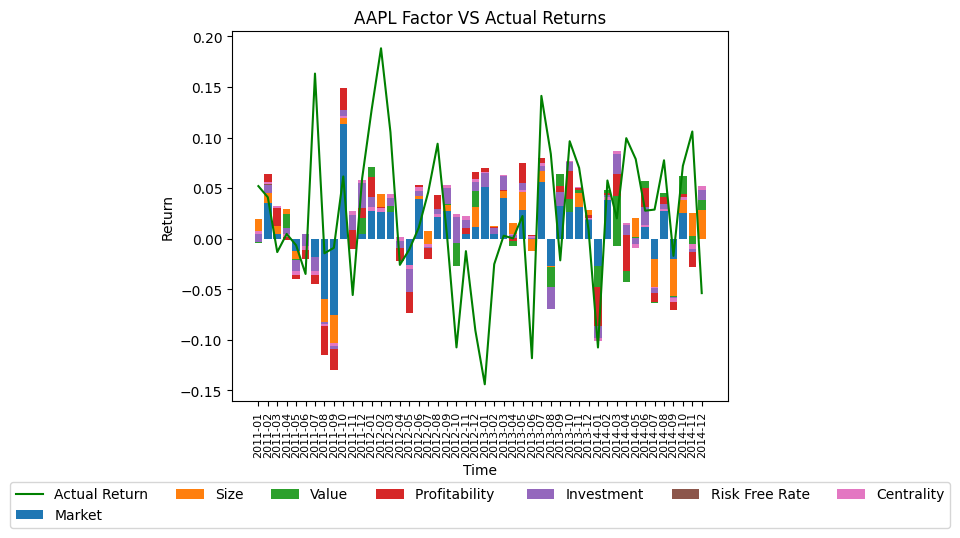

In [194]:
num_rows = len(six_factor_data)

print("Number of rows:", num_rows)
time=num_rows

categories = ['Market', 'Size', 'Value','Profitability ', 'Investment','Risk Free Rate','Centrality']
time_periods = six_factor_data.index[:time].tolist()
data = np.array([six_factor_data['mkt'].tolist()[:time],  # mkt
                 six_factor_data['smb'].tolist()[:time],   # smb
                 six_factor_data['hml'].tolist()[:time],
                 six_factor_data['rmw'].tolist()[:time],   # Category 2
                 six_factor_data['cma'].tolist()[:time],
                 six_factor_data['rf'].tolist()[:time],   # cma
                 six_factor_data[Stock_OLS].tolist()[:time]
                 ])  

# Create stacked bar chart
fig, ax = plt.subplots()

# Plotting each category's bar
bottom = np.zeros(len(time_periods))
for i, category in enumerate(categories):
    ax.bar(time_periods, data[i], bottom=bottom, label=category)
    bottom += data[i]

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Return')
ax.set_title(RISKY_ASSET+ ' Factor VS Actual Returns')
ax.legend()

# Calculate trend line
x = np.arange(len(time_periods))
y=five_factor_data['rtn'].tolist()[:time]

# Plot the trend line
ax.plot(x, y, color='green', label='Actual Return')
ax.legend()

# Set the legend below the graph
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(categories))

# Set the x-axis tick labels to display horizontally
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
# Display the chart
plt.show()
